In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../Dataset/iRent去識別化數據(僅供本次賽事使用)_20220627/iRent顧客租車交易資料.csv', encoding= 'big5')
df['Date'] = pd.to_datetime(df['iRent_7']).dt.date
print(df.shape)
df.head()

(403331, 16)


,iRent_1,iRent_2,iRent_3,iRent_4,iRent_5,iRent_6,iRent_7,iRent_8,iRent_9,iRent_10,iRent_11,iRent_12,iRent_13,iRent_14,iRent_15,Date
0,A10002139,31-35,M,台北市,文山區,40366241,2021/04/01 18:06:14,516,2021/04/01 18:10:20,2021/04/01 22:12:29,40.0,RCF-6972,TOYOTA/PRIUSc,car,201904,2021-04-01
1,A10002478,31-35,M,台北市,中正區,73561565,2021/04/11 11:40:08,37,2021/04/11 11:42:09,2021/04/11 12:06:09,5.5,EWA-0325,KYMCO/MANY-110,motor,201909,2021-04-11
2,A10002478,31-35,M,台北市,中正區,113588372,2021/04/24 12:05:24,19,2021/04/24 12:07:29,2021/04/24 12:19:04,2.5,EWH-7300,KYMCO/MANY-110,motor,201911,2021-04-24
3,A10002651,31-35,M,新北市,永和區,79976100,2021/04/13 13:36:36,717,2021/04/13 13:40:21,2021/04/13 16:41:53,90.0,RCK-8260,TOYOTA/YARIS,car,201901,2021-04-13
4,A10002984,31-35,M,台北市,文山區,58906802,2021/04/06 19:30:49,284,2021/04/06 19:42:04,2021/04/06 20:46:05,45.0,RCF-8171,TOYOTA/PRIUSc,car,201906,2021-04-06


In [5]:
max(df['Date'])

datetime.date(2021, 4, 30)

In [6]:
df_recency = df.groupby(by = 'iRent_1', as_index= False)['Date'].max()

df_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency

,CustomerID,LastPurchaseDate,Recency
0,A10002139,2021-04-01,29
1,A10002478,2021-04-24,6
2,A10002651,2021-04-13,17
3,A10002984,2021-04-06,24
4,A10003278,2021-04-17,13
...,...,...,...
122305,Z103337827,2021-04-21,9
122306,Z103337999,2021-04-22,8
122307,Z103338464,2021-04-27,3
122308,Z103340951,2021-04-23,7


In [7]:
frequency_df = df.drop_duplicates().groupby(
    by=['iRent_1'], as_index=False)['Date'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df

,CustomerID,Frequency
0,A10002139,1
1,A10002478,2
2,A10002651,1
3,A10002984,1
4,A10003278,1
...,...,...
122305,Z103337827,1
122306,Z103337999,2
122307,Z103338464,4
122308,Z103340951,1


In [8]:
monetary_df = df.groupby(by='iRent_1', as_index=False)['iRent_8'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df

,CustomerID,Monetary
0,A10002139,516
1,A10002478,56
2,A10002651,717
3,A10002984,284
4,A10003278,6492
...,...,...
122305,Z103337827,144
122306,Z103337999,394
122307,Z103338464,4224
122308,Z103340951,18


In [9]:
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(
    columns='LastPurchaseDate')
rfm_df

,CustomerID,Recency,Frequency,Monetary
0,A10002139,29,1,516
1,A10002478,6,2,56
2,A10002651,17,1,717
3,A10002984,24,1,284
4,A10003278,13,1,6492
...,...,...,...,...
122305,Z103337827,9,1,144
122306,Z103337999,8,2,394
122307,Z103338464,3,4,4224
122308,Z103340951,7,1,18


In [10]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,A10002139,29,1,516,3.310902,23.154280,23.154280
1,A10002478,6,2,56,67.335769,56.161802,56.161802
2,A10002651,17,1,717,33.356406,23.154280,23.154280
3,A10002984,24,1,284,16.666880,23.154280,23.154280
4,A10003278,13,1,6492,43.407892,23.154280,23.154280
...,...,...,...,...,...,...,...
122305,Z103337827,9,1,144,55.676900,23.154280,23.154280
122306,Z103337999,8,2,394,58.650260,56.161802,56.161802
122307,Z103338464,3,4,4224,82.055588,79.390892,79.390892
122308,Z103340951,7,1,18,62.364503,23.154280,23.154280


In [11]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,A10002139,1.01
1,A10002478,2.89
2,A10002651,1.23
3,A10002984,1.11
4,A10003278,1.31
5,A10007742,1.07
6,A10007816,1.53


In [12]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] > 4.5, "Top Customers",
							(np.where(rfm_df['RFM_Score'] > 4, "High value Customer",
							(np.where(rfm_df['RFM_Score'] > 3,"Medium Value Customer",
							np.where(rfm_df['RFM_Score'] > 1.6,'Low Value Customers', 
							'Lost Customers'))))))
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']]

,CustomerID,RFM_Score,Customer_segment
0,A10002139,1.01,Lost Customers
1,A10002478,2.89,Low Value Customers
2,A10002651,1.23,Lost Customers
3,A10002984,1.11,Lost Customers
4,A10003278,1.31,Lost Customers
...,...,...,...
122305,Z103337827,1.40,Lost Customers
122306,Z103337999,2.83,Low Value Customers
122307,Z103338464,3.99,Medium Value Customer
122308,Z103340951,1.45,Lost Customers


In [13]:
rfm_df[rfm_df['Customer_segment'] == 'Top Customers']

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
14,A10011820,0,9,223,100.00,93.56,93.56,4.73,Top Customers
20,A10015483,0,9,4876,100.00,93.56,93.56,4.73,Top Customers
48,A10033255,3,13,2017,82.06,96.50,96.50,4.72,Top Customers
52,A10035385,3,30,620,82.06,99.23,99.23,4.83,Top Customers
53,A10036743,0,10,630,100.00,94.58,94.58,4.77,Top Customers
...,...,...,...,...,...,...,...,...,...
122228,Y103264969,1,15,2185,92.06,97.22,97.22,4.82,Top Customers
122236,Y103272190,0,22,1356,100.00,98.60,98.60,4.94,Top Customers
122277,Z103309453,2,9,1340,86.44,93.56,93.56,4.62,Top Customers
122280,Z103315174,0,13,1948,100.00,96.50,96.50,4.85,Top Customers


In [14]:
rfm_df[rfm_df['Customer_segment'] == 'High value Customer']

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
13,A10011299,8,6,383,58.65,88.05,88.05,4.18,High value Customer
27,A10023716,12,6,2375,47.14,88.05,88.05,4.10,High value Customer
37,A10027862,2,4,1838,86.44,79.39,79.39,4.02,High value Customer
38,A10029694,3,6,235,82.06,88.05,88.05,4.36,High value Customer
74,A10054763,7,6,102,62.36,88.05,88.05,4.21,High value Customer
...,...,...,...,...,...,...,...,...,...
122284,Z103318106,8,5,128,58.65,84.58,84.58,4.03,High value Customer
122290,Z103321808,0,5,1793,100.00,84.58,84.58,4.34,High value Customer
122293,Z103323903,4,6,93,77.69,88.05,88.05,4.32,High value Customer
122296,Z103324665,3,7,4300,82.06,90.49,90.49,4.46,High value Customer


In [15]:
rfm_df[rfm_df['Customer_segment'] == 'Medium Value Customer']

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
7,A10007849,26,3,108,11.51,71.13,71.13,3.11,Medium Value Customer
12,A10010362,15,4,1142,37.42,79.39,79.39,3.65,Medium Value Customer
19,A10015328,4,3,75,77.69,71.13,71.13,3.61,Medium Value Customer
21,A10018411,12,5,148,47.14,84.58,84.58,3.95,Medium Value Customer
30,A10025982,0,3,0,100.00,71.13,71.13,3.77,Medium Value Customer
...,...,...,...,...,...,...,...,...,...
122286,Z103319075,22,3,312,20.40,71.13,71.13,3.18,Medium Value Customer
122291,Z103322675,1,3,288,92.06,71.13,71.13,3.71,Medium Value Customer
122295,Z103324302,12,4,258,47.14,79.39,79.39,3.73,Medium Value Customer
122299,Z103329036,13,4,5804,43.41,79.39,79.39,3.70,Medium Value Customer


In [16]:
rfm_df[rfm_df['Customer_segment'] == 'Low Value Customers']

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
1,A10002478,6,2,56,67.34,56.16,56.16,2.89,Low Value Customers
25,A10019489,22,2,75,20.40,56.16,56.16,2.54,Low Value Customers
26,A10019619,3,2,6492,82.06,56.16,56.16,3.00,Low Value Customers
29,A10025845,7,2,37,62.36,56.16,56.16,2.85,Low Value Customers
31,A10026271,2,1,885,86.44,23.15,23.15,1.63,Low Value Customers
...,...,...,...,...,...,...,...,...,...
122292,Z103323004,26,2,1797,11.51,56.16,56.16,2.47,Low Value Customers
122298,Z103328845,2,1,120,86.44,23.15,23.15,1.63,Low Value Customers
122301,Z103334426,14,2,112,40.00,56.16,56.16,2.69,Low Value Customers
122303,Z103335226,19,2,3666,28.64,56.16,56.16,2.60,Low Value Customers


In [17]:
rfm_df[rfm_df['Customer_segment'] == 'Lost Customers']

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,A10002139,29,1,516,3.31,23.15,23.15,1.01,Lost Customers
2,A10002651,17,1,717,33.36,23.15,23.15,1.23,Lost Customers
3,A10002984,24,1,284,16.67,23.15,23.15,1.11,Lost Customers
4,A10003278,13,1,6492,43.41,23.15,23.15,1.31,Lost Customers
5,A10007742,26,1,45,11.51,23.15,23.15,1.07,Lost Customers
...,...,...,...,...,...,...,...,...,...
122297,Z103328681,10,1,120,52.94,23.15,23.15,1.38,Lost Customers
122302,Z103334668,18,1,582,31.28,23.15,23.15,1.22,Lost Customers
122304,Z103337783,15,1,21,37.42,23.15,23.15,1.26,Lost Customers
122305,Z103337827,9,1,144,55.68,23.15,23.15,1.40,Lost Customers


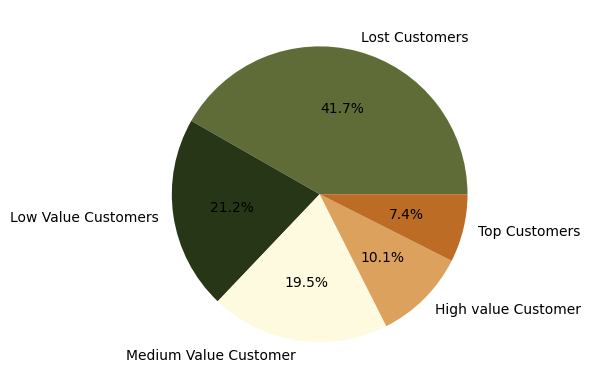

In [20]:
plt.pie(rfm_df.Customer_segment.value_counts(),
		labels=rfm_df.Customer_segment.value_counts().index,
		autopct='%.1f%%', colors= ['#606C38','#283618', '#FEFAE0', '#DDA15E', '#BC6C25'])
plt.show()